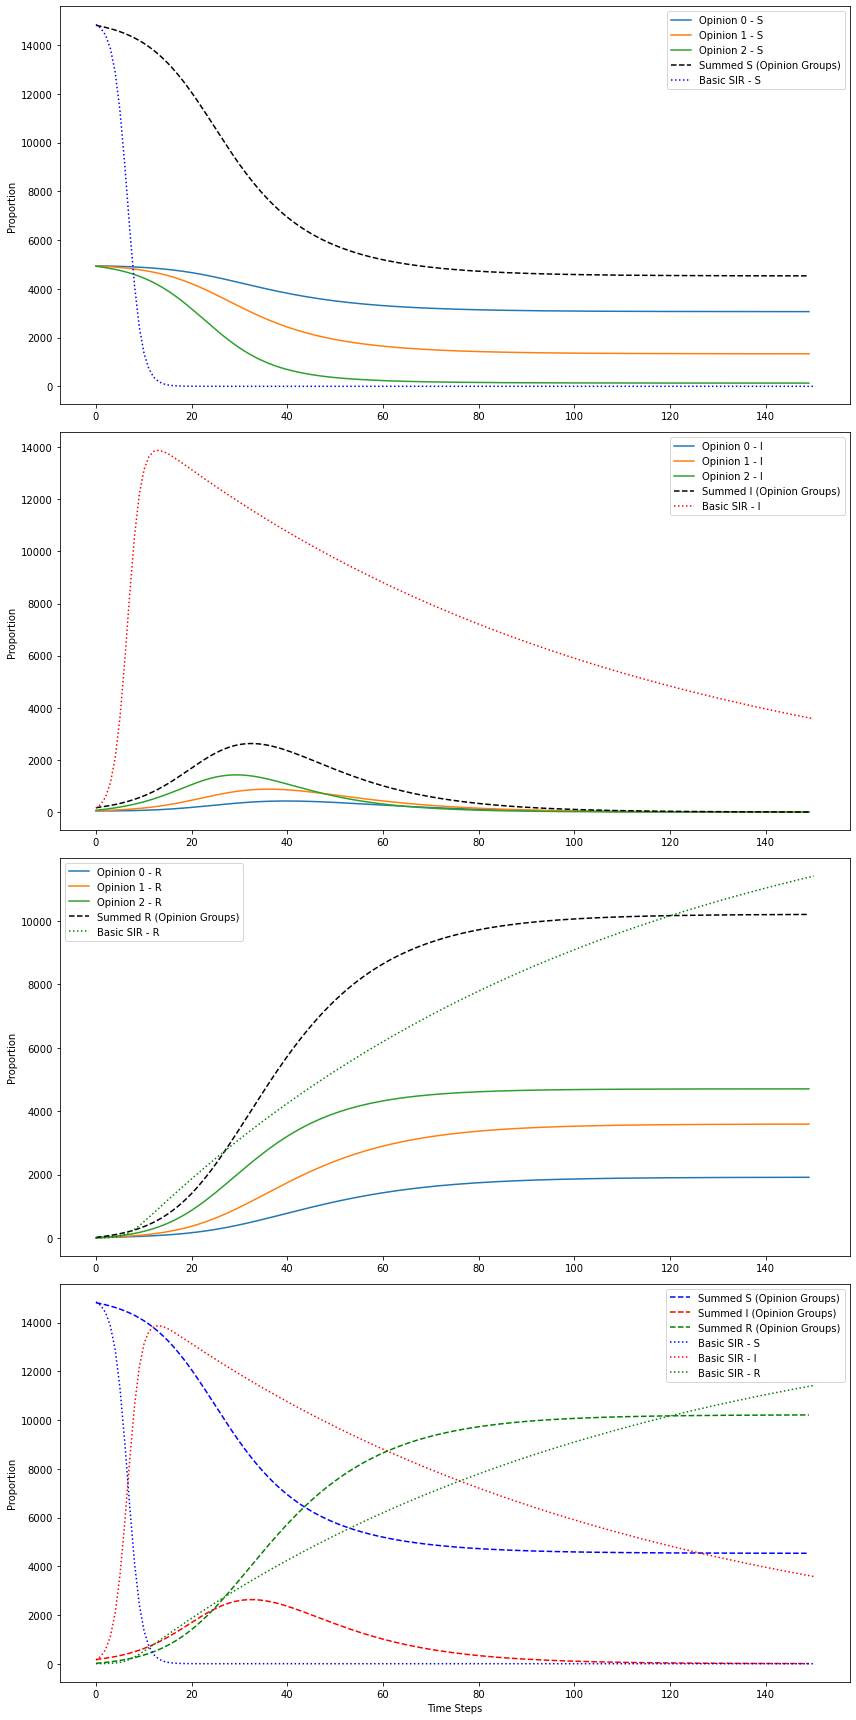

Fitted beta (S): 0.194510994246356, Fitted gamma (S): 0.09999999999999978
Fitted beta (I): 0.2305009496471487, Fitted gamma (I): 0.09999999999999958
Fitted beta (R): 1.2993537556355907, Fitted gamma (R): 0.011423237882931082
Goodness of fit for S:
R^2: 0.8610, MAE: 1090.7911, RMSE: 1234.5840
Goodness of fit for I:
R^2: 0.9154, MAE: 146.2173, RMSE: 250.9883
Goodness of fit for R:
R^2: 0.9143, MAE: 913.0664, RMSE: 1048.6311


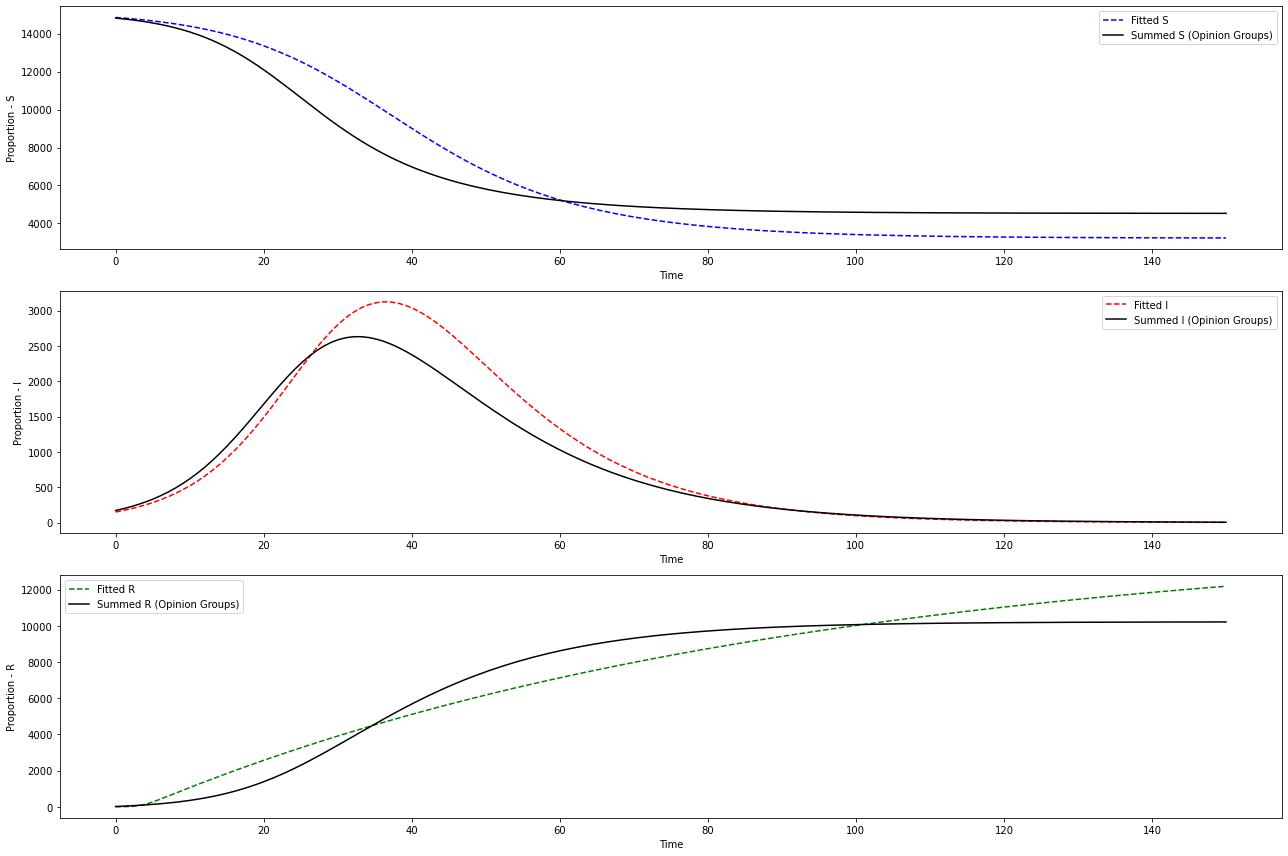

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R  # S_0 is starting susceptible
beta = 0.7
gamma = 0.01
MaxTime = 150
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    # This is basically the softmax function that we are using to compute the probability distribution
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(t, y, row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N - (3 ** n) * gamma * row[f'P_I_{O}']

def dR(t, y, row, O, gamma, n):
    return (3 ** n) * gamma * row[f'P_I_{O}']

# Runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]  # Step size is based on the t array

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        U[j + 1] = U[j] + h * k2

    return U[-1]

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)  # Time step for the Runge-Kutta method

    # Define the column names for the DataFrame
    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]

    # Create an empty DataFrame with the specified columns
    data = pd.DataFrame(columns=columns)

    # Initialization of the row with the initial values
    row = initial_values.copy()

    # Run the simulation for the specified number of steps
    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Function to plot the simulation results
def plot_simulation_2d(data, basic_S, basic_I, basic_R, RunTime, n):
    num_plots = n + 1  # Total number of opinion groups
    fig, axes = plt.subplots(4, 1, figsize=(12, 24))

    # Plot S, I, R for each opinion group
    for i in range(num_plots):
        axes[0].plot(data.index, data[f'P_S_{i}'], label=f'Opinion {i} - S')
        axes[1].plot(data.index, data[f'P_I_{i}'], label=f'Opinion {i} - I')
        axes[2].plot(data.index, data[f'P_R_{i}'], label=f'Opinion {i} - R')

    # Plot summed proportions for opinion groups SIR
    summed_S = data[[f'P_S_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(num_plots)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(num_plots)]].sum(axis=1)

    axes[0].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    plt.tight_layout()
    plt.show()

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Plot the results for both the basic SIR model and the opinion groups SIR model
plot_simulation_2d(data, basic_S, basic_I, basic_R, RunTime, n)

# Define the SIR model function for curve fitting
def SIR_model(t, beta, gamma):
    y_0 = int_S, int_I, int_R
    coord = odeint(Find_Deriv, y_0, t, args=(N, beta, gamma))
    S, I, R = coord.T
    return S, I, R

# Function to fit the SIR model to data
def fit_SIR_model(data, t):
    summed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1).values
    summed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1).values
    summed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1).values

    # Fit the model to the summed S, I, R data
    popt_S, _ = curve_fit(lambda t, beta, gamma: SIR_model(t, beta, gamma)[0], t, summed_S, p0=[0.7, 0.01], bounds=(0, [4., 0.1]))
    popt_I, _ = curve_fit(lambda t, beta, gamma: SIR_model(t, beta, gamma)[1], t, summed_I, p0=[0.7, 0.01], bounds=(0, [4., 0.1]))
    popt_R, _ = curve_fit(lambda t, beta, gamma: SIR_model(t, beta, gamma)[2], t, summed_R, p0=[0.7, 0.01], bounds=(0, [4., 0.1]))

    return popt_S, popt_I, popt_R

# Perform the curve fitting
popt_S, popt_I, popt_R = fit_SIR_model(data, RunTime)

# Extract the fitted parameters
fitted_beta_S, fitted_gamma_S = popt_S
fitted_beta_I, fitted_gamma_I = popt_I
fitted_beta_R, fitted_gamma_R = popt_R

print(f"Fitted beta (S): {fitted_beta_S}, Fitted gamma (S): {fitted_gamma_S}")
print(f"Fitted beta (I): {fitted_beta_I}, Fitted gamma (I): {fitted_gamma_I}")
print(f"Fitted beta (R): {fitted_beta_R}, Fitted gamma (R): {fitted_gamma_R}")

# Calculate the fitted values using the SIR model
fitted_S_S, fitted_I_S, fitted_R_S = SIR_model(RunTime, fitted_beta_S, fitted_gamma_S)
fitted_S_I, fitted_I_I, fitted_R_I = SIR_model(RunTime, fitted_beta_I, fitted_gamma_I)
fitted_S_R, fitted_I_R, fitted_R_R = SIR_model(RunTime, fitted_beta_R, fitted_gamma_R)

# Define the function to calculate goodness of fit metrics
def goodness_of_fit(observed, fitted):
    r2 = r2_score(observed, fitted)
    mae = mean_absolute_error(observed, fitted)
    rmse = np.sqrt(mean_squared_error(observed, fitted))
    return r2, mae, rmse

# Calculate goodness of fit for S, I, and R
observed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1).values
observed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1).values
observed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1).values

r2_S, mae_S, rmse_S = goodness_of_fit(observed_S, fitted_S_S)
r2_I, mae_I, rmse_I = goodness_of_fit(observed_I, fitted_I_I)
r2_R, mae_R, rmse_R = goodness_of_fit(observed_R, fitted_R_R)

print(f"Goodness of fit for S:")
print(f"R^2: {r2_S:.4f}, MAE: {mae_S:.4f}, RMSE: {rmse_S:.4f}")
print(f"Goodness of fit for I:")
print(f"R^2: {r2_I:.4f}, MAE: {mae_I:.4f}, RMSE: {rmse_I:.4f}")
print(f"Goodness of fit for R:")
print(f"R^2: {r2_R:.4f}, MAE: {mae_R:.4f}, RMSE: {rmse_R:.4f}")

# Plot the fitted SIR model against the simulation data
plt.figure(figsize=(18, 12))

# Plot for S
plt.subplot(3, 1, 1)
plt.plot(RunTime, fitted_S_S, label='Fitted S', color='blue', linestyle='--')
plt.plot(RunTime, observed_S, label='Summed S (Opinion Groups)', color='black')
plt.xlabel('Time')
plt.ylabel('Proportion - S')
plt.legend()

# Plot for I
plt.subplot(3, 1, 2)
plt.plot(RunTime, fitted_I_I, label='Fitted I', color='red', linestyle='--')
plt.plot(RunTime, observed_I, label='Summed I (Opinion Groups)', color='black')
plt.xlabel('Time')
plt.ylabel('Proportion - I')
plt.legend()

# Plot for R
plt.subplot(3, 1, 3)
plt.plot(RunTime, fitted_R_R, label='Fitted R', color='green', linestyle='--')
plt.plot(RunTime, observed_R, label='Summed R (Opinion Groups)', color='black')
plt.xlabel('Time')
plt.ylabel('Proportion - R')
plt.legend()

plt.tight_layout()
plt.show()

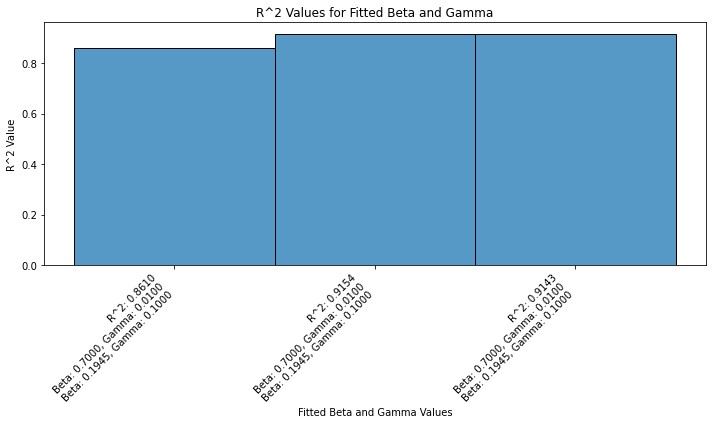

In [7]:
import seaborn as sns
import pandas as pd

# Calculate goodness of fit for S, I, and R
observed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1).values
observed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1).values
observed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1).values

# Calculate goodness of fit for the fitted SIR model
r2_S, mae_S, rmse_S = goodness_of_fit(observed_S, fitted_S_S)
r2_I, mae_I, rmse_I = goodness_of_fit(observed_I, fitted_I_I)
r2_R, mae_R, rmse_R = goodness_of_fit(observed_R, fitted_R_R)

# Create a DataFrame with R^2 values and corresponding beta, gamma values
fit_data = pd.DataFrame({
    'R2': [r2_S, r2_I, r2_R],
    'Beta': [fitted_beta_S, fitted_beta_I, fitted_beta_R],
    'Gamma': [fitted_gamma_S, fitted_gamma_I, fitted_gamma_R]
})

# Create labels for the x-axis
fit_data['Labels'] = [
    f"R^2: {r2_S:.4f}\nBeta: {beta:.4f}, Gamma: {gamma:.4f}\nBeta: {fitted_beta_S:.4f}, Gamma: {fitted_gamma_S:.4f}",
    f"R^2: {r2_I:.4f}\nBeta: {beta:.4f}, Gamma: {gamma:.4f}\nBeta: {fitted_beta_S:.4f}, Gamma: {fitted_gamma_S:.4f}",
    f"R^2: {r2_R:.4f}\nBeta: {beta:.4f}, Gamma: {gamma:.4f}\nBeta: {fitted_beta_S:.4f}, Gamma: {fitted_gamma_S:.4f}"
]

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=fit_data, x='Labels', weights='R2', bins=3, kde=False)
plt.xlabel('Fitted Beta and Gamma Values')
plt.ylabel('R^2 Value')
plt.title('R^2 Values for Fitted Beta and Gamma')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
